## 数据处理

### 加载格网

In [63]:
import os
import glob
from tqdm import tqdm

import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# 设置matplotlib正常显示中文和负号
matplotlib.rcParams['font.sans-serif']=['SimHei'] # 用黑体显示中文
matplotlib.rcParams['axes.unicode_minus']=False # 正常显示负号

In [64]:
gdf = gpd.read_file('data/矢量/grid.shp')
china  = gpd.read_file('https:/geojson.cn/api/data/china.json')

In [65]:
gdf

,ENG_NAME,FID,geometry
0,Xinjiang,0,"POLYGON ((73.45746 38.22640, 73.45746 38.72640..."
1,Xinjiang,1,"POLYGON ((73.45746 38.72640, 73.45746 39.22640..."
2,Xinjiang,2,"POLYGON ((73.45746 39.22640, 73.45746 39.72640..."
3,Xinjiang,3,"POLYGON ((73.45746 39.72640, 73.45746 40.22640..."
4,Xinjiang,4,"POLYGON ((73.95746 38.22640, 73.95746 38.72640..."
...,...,...,...
5095,Heilongjiang,5234,"POLYGON ((133.95746 48.22640, 133.95746 48.726..."
5096,Heilongjiang,5235,"POLYGON ((134.45746 47.22640, 134.45746 47.726..."
5097,Heilongjiang,5236,"POLYGON ((134.45746 47.72640, 134.45746 48.226..."
5098,Heilongjiang,5237,"POLYGON ((134.45746 48.22640, 134.45746 48.726..."


In [66]:
gdf = gdf.sort_values('FID').reset_index(drop=True)

<Axes: >

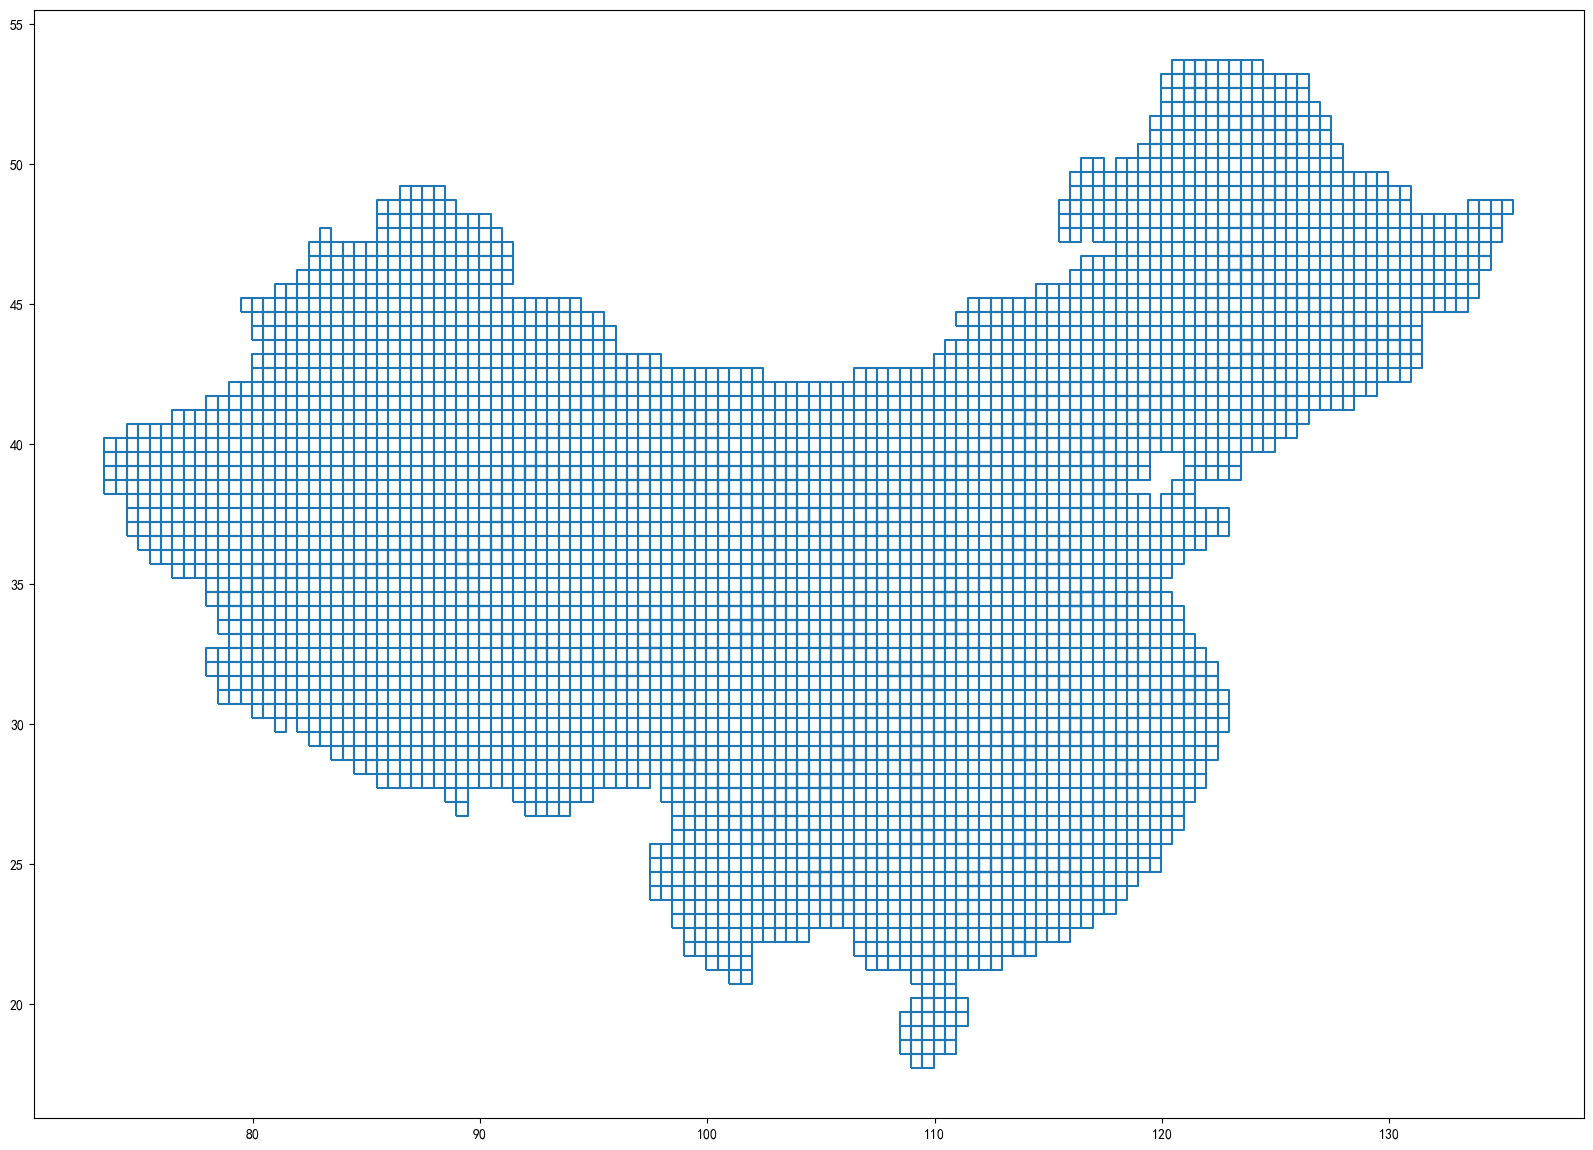

In [67]:
gdf.boundary.plot(figsize=(20,20))

### 极端降雨

In [33]:
er1 = pd.read_csv('data/CSV/中间数据集/df_baoyu_50.csv')
er2 = pd.read_csv('data/CSV/中间数据集/df_repe_90.csv')

In [34]:
er1

,FID,date,neighbors,neighbor_count
0,1120,2017-08-10,FID date\n15 1289 2017-08-...,16
1,1120,2000-08-09,FID date\n143 1206 2000-08-09...,14
2,1120,2015-08-20,FID date\n13 1247 2015-08-20...,18
3,1120,2016-08-09,FID date\n194 1206 2016-08-09...,14
4,1120,1998-08-20,FID date\n66 1247 1998-08-20...,14
...,...,...,...,...
29075,5010,1995-07-13,FID date\n19652 4872 1995-07-...,7
29076,5011,1995-07-13,FID date\n21368 4873 1995-07-...,6
29077,5022,1990-08-24,FID date\n10792 5026 1990-08-...,9
29078,5023,1990-08-24,FID date\n10792 5026 1990-08-...,8


In [35]:
er2

,FID,date,neighbors,neighbor_count
0,1331,1990-07-06,FID date\n380 1247 1990-07-08\n...,9
1,1368,1990-07-06,FID date\n380 1247 1990-07-08\n...,8
2,1368,1990-09-29,FID date\n3011 1407 1990-09-27...,6
3,1369,1990-09-29,FID date\n932 1368 1990-09-27...,7
4,1289,1991-06-30,FID date\n94 1368 1991-07-02\n...,7
...,...,...,...,...
959,3736,2020-07-09,FID date\n1022 3660 2020-07-09\n...,14
960,2414,2020-08-13,FID date\n796 2250 2020-08-11...,6
961,2358,2020-08-15,FID date\n2651 2306 2020-08-17\n...,5
962,2141,2020-08-18,FID date\n456 2250 2020-08-16\n...,11


### 降雨按照日进行分割

In [8]:
path = 'data/CSV/降雨/'
csvs = glob.glob(path + '*')
df = pd.read_csv(csvs[0])

In [9]:
for csv in csvs:
    df = pd.read_csv(csv)
    columns = df.drop(columns=['lon','lat','FID']).columns
    for column in tqdm(columns, desc=f"Processing columns for {csv}", ncols=100):
        gdf[['ENG_NAME','FID']].merge(df[[column]+['FID']], on='FID', how='left').rename(columns={column:'rain'}).to_csv(f'data/CSV/问题三模型数据集/{column}.csv', index=False)

Processing columns for data/CSV/降雨\rain_2020.csv: 100%|████████| 365/365 [00:03<00:00, 109.44it/s]


### DEM相关数据不出现多时序——先合并到日降水

In [10]:
csvs = glob.glob('data/CSV/问题三模型数据集/*.csv')
dems = glob.glob('data/CSV/DEM/*.csv')

In [11]:
dem = pd.read_csv(dems[0]).rename(columns={'chdem_105':'dem'})
aspect = pd.read_csv(dems[1]).rename(columns={'chdem_Aspect':'aspect'})
hillshade = pd.read_csv(dems[2]).rename(columns={'chdem_hillshade':'hillshade'})
slope = pd.read_csv(dems[3]).rename(columns={'chdem_Slope':'slope'})

for csv in tqdm(csvs, desc='Processing', ncols=100):
    df = pd.read_csv(csv)
    df = df.merge(dem, on='FID', how='left')
    df = df.merge(aspect, on='FID', how='left')
    df = df.merge(hillshade, on='FID', how='left')
    df = df.merge(slope, on='FID', how='left')
    df.to_csv('data/CSV/日降雨量汇总/' + csv.split('\\')[1], index=False)

Processing: 100%|█████████████████████████████████████████████| 11322/11322 [06:45<00:00, 27.95it/s]


### 把每年的其它数据汇总到降雨的日数据中

In [12]:
years = [str(year) for year in range(1990,2021)]

#### 土地利用

In [13]:
for year in years:
    csvs = glob.glob(f'data/CSV/日降雨量汇总/*{year}*.csv')
    land = glob.glob(f'data/CSV/土地利用/*{1990}*.csv')
    df_land = pd.read_csv(land[0]).drop(columns=['lon','lat'])
    df_land.columns = df_land.columns.str.replace(r'-\d+', '', regex=True)
    for csv in tqdm(csvs, desc="Processing", ncols=100):
        df = pd.read_csv(csv)
        df = df.merge(df_land, on='FID', how='left')
        df.to_csv('data/CSV/日降雨量汇总/' + csv.split('\\')[1], index=False)

Processing: 100%|█████████████████████████████████████████████████| 365/365 [00:22<00:00, 16.11it/s]


### 人口
- 人口数据截止2015年
- 使用待商榷

In [81]:
er2[er2['date']=='1990-07-06']

,FID,date,neighbors,neighbor_count
0,1331,1990-07-06,FID date\n380 1247 1990-07-08\n...,9
1,1368,1990-07-06,FID date\n380 1247 1990-07-08\n...,8


In [80]:
er1[er1['date']=='1990-07-06']

,FID,date,neighbors,neighbor_count
889,1289,1990-07-06,FID date\n380 1247 1990-07-08...,21
1146,1290,1990-07-06,FID date\n380 1247 1990-07-08...,19
1356,1330,1990-07-06,FID date\n380 1247 1990-07-08...,19
1529,1331,1990-07-06,FID date\n380 1247 1990-07-08...,18
2048,1368,1990-07-06,FID date\n380 1247 1990-07-08...,18
2400,1369,1990-07-06,FID date\n380 1247 1990-07-08...,18
2671,1407,1990-07-06,FID date\n380 1247 1990-07-08...,15
3028,1444,1990-07-06,FID date\n569 1289 1990-07-08...,8


## 定标签

- 0：无灾害
- 1：灾害强度低
- 2：灾害强度高

In [167]:
csvs = glob.glob('data/CSV/日降雨量汇总/*.csv')
csv_out = 'data/CSV/Q3数据集带标签/'

In [78]:
years = [str(year) for year in range(2010,2021)]
csvs = [csv for csv in csvs if csv.split('\\')[1].split('.')[0].split('-')[0] in years]



In [104]:
from sklearn.preprocessing import MinMaxScaler

# 创建一个MinMaxScaler对象，缩放到0-1之间
scaler = MinMaxScaler(feature_range=(0, 2))
# 假设df_all['2000']是你想要缩放的数据列
data_to_scale = df_all[['2000']].values.reshape(-1, 1)

# 拟合并转换数据
scaled_data = scaler.fit_transform(data_to_scale)

# 将缩放后的数据乘以2得到0到2之间的范围
scaled_data_0_to_2 = scaled_data * 2

In [133]:
new_data['FID'] = df0['FID']
gdf1 = gdf.merge(new_data, on='FID', how='left')


In [131]:
new_data = pd.DataFrame()

for year in years:
    data_to_scale = df_all[year].values.reshape(-1, 1)
    scaled_data = scaler.fit_transform(data_to_scale)
    # 展平为一维数组
    scaled_data_flattened = (scaled_data).ravel()
    new_data[year] = pd.Series(scaled_data_flattened)



In [130]:
df_all = pd.DataFrame()
df0 = gdf[['FID','ENG_NAME']].copy()

for year in years:
    for csv in [csv for csv in csvs if csv.split('\\')[1].split('.')[0].split('-')[0] == year]:
        df = pd.read_csv(csv)
        n = csv.split('\\')[1].split('.')[0]
        df0 = df0.merge(df[['FID','rain']], on='FID', how='left').rename(columns={'rain':n})
    df_all[year] = df0.drop(columns=['FID','ENG_NAME']).fillna(0).max(axis=1)

In [36]:
# 添加标签
need_col = ['rain','dem','aspect','hillshade','slope','cropland','forest','grass','shrub','wetland','buildup']
for csv in tqdm(csvs, desc="Processing", ncols=100):
    df0 = pd.DataFrame()
    df = pd.read_csv(csv)
    df = df.sort_values('FID').reset_index(drop=True)
    
    date = os.path.basename(csv).split('.')[0]
    df_er1 = er1[er1['date']==date].copy()
    df_er2 = er2[er2['date']==date].copy()
    df_er1['y'] = 1
    df_er2['y'] = 2
    
    df0 = pd.concat([df_er1,df_er2])
    df0 = df0.sort_values('y').drop_duplicates(subset=['FID','date'], keep='last')
    
    if len(df0):
        df = df.merge(df0[['FID','y']], on='FID', how='left')
        df['y'].fillna(0, inplace=True)
    else:
        df['y'] = 0
    df.fillna(0, inplace=True)
    df_standardized = df[need_col].apply(lambda x: (x - x.mean()) / x.std(), axis=0)  # 列上进行归一化
    df_standardized['y'] = df['y']
    df_standardized.to_csv(csv_out + os.path.basename(csv), index=False)

Processing: 100%|█████████████████████████████████████████████| 11322/11322 [14:56<00:00, 12.63it/s]


## 空间权重矩阵
- 参考: [A graph neural network framework for spatial geodemographic classification](https://www.tandfonline.com/doi/full/10.1080/13658816.2023.2254382)  

- 使用图神经网络进行空间预测

In [6]:
from libpysal.weights import Queen, KNN

import networkx as nx

In [8]:
def haversine(coord1, coord2):
    # 地球半径，单位为公里
    R = 6371.0  
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c  # 返回距离，单位为公里

### Queen’s contiguity

In [7]:
w = Queen.from_dataframe(gdf, use_index=True)  #  构建邻接矩阵 (Queen 邻接关系)
adj_matrix = w.sparse  # 将邻接矩阵转换为稀疏矩阵格式

C:\Users\15499\AppData\Local\Temp\ipykernel_11088\2700156124.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.geometry.centroid


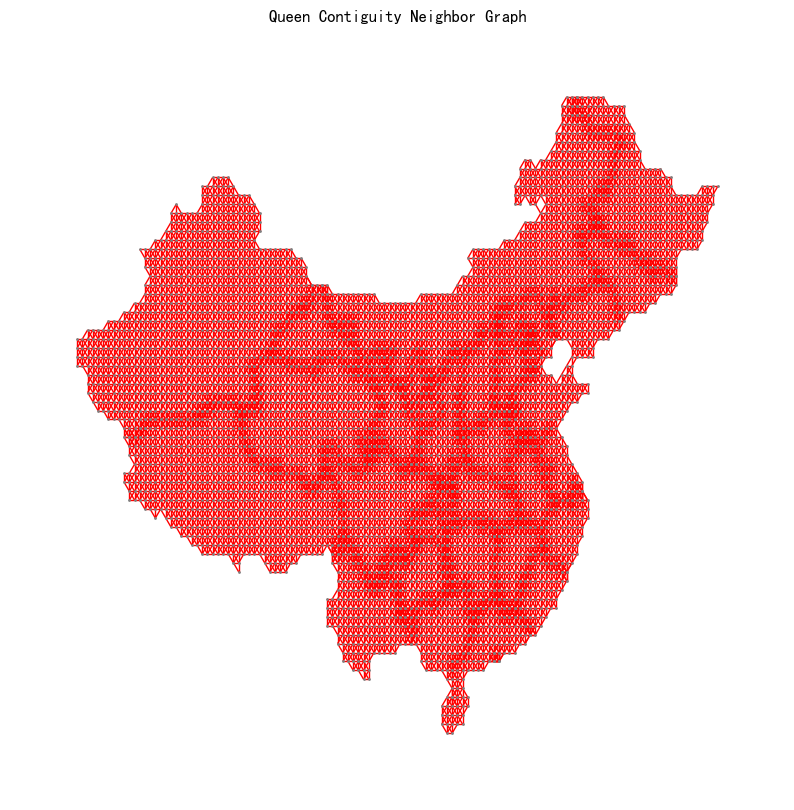

In [8]:
G = nx.from_numpy_array(adj_matrix)
# 提取几何的中心点作为节点位置
centroids = gdf.geometry.centroid
pos = {i: (centroid.x, centroid.y) for i, centroid in enumerate(centroids)}

# 绘制图形
fig, ax = plt.subplots(figsize=(10, 10))
# gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
nx.draw(
    G, pos,
    ax=ax,
    node_size=1,
    node_color="grey",
    edge_color="red",
    with_labels=False
)
plt.title('Queen Contiguity Neighbor Graph')
plt.show()

In [11]:
# centroids = gdf.geometry.centroid  # 获取每个要素的几何中心点
# coords = centroids.apply(lambda point: (point.y, point.x)).tolist()  # 提取经纬度
# dist_matrix = squareform(pdist(coords, metric=haversine))  # 使用 pdist 和 haversine 计算距离矩阵
# # 使用距离的倒数作为权重矩阵
# weight_matrix = 1 / (dist_matrix + np.eye(dist_matrix.shape[0]))  # 避免除以 0

In [30]:
weight_matrix

array([[1.00000000e+00, 1.79864321e-02, 8.99321606e-03, ...,
        2.03230350e-04, 2.03664186e-04, 2.02173308e-04],
       [1.79864321e-02, 1.00000000e+00, 1.79864321e-02, ...,
        2.04479985e-04, 2.04943257e-04, 2.03436721e-04],
       [8.99321606e-03, 1.79864321e-02, 1.00000000e+00, ...,
        2.05729953e-04, 2.06223482e-04, 2.04701430e-04],
       ...,
       [2.03230350e-04, 2.04479985e-04, 2.05729953e-04, ...,
        1.00000000e+00, 1.79864321e-02, 1.49689938e-02],
       [2.03664186e-04, 2.04943257e-04, 2.06223482e-04, ...,
        1.79864321e-02, 1.00000000e+00, 2.71318329e-02],
       [2.02173308e-04, 2.03436721e-04, 2.04701430e-04, ...,
        1.49689938e-02, 2.71318329e-02, 1.00000000e+00]])

In [31]:
weight_matrix.shape

(5239, 5239)

### K-nearest neighbours (KNN)

In [10]:
# 使用KNN构建邻接矩阵，k表示邻居个数
k = 5
knn = KNN.from_dataframe(gdf, k=k)
adj_matrix = knn.sparse

G = nx.from_numpy_array(adj_matrix)

C:\Users\15499\AppData\Local\Temp\ipykernel_11088\261645791.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.geometry.centroid


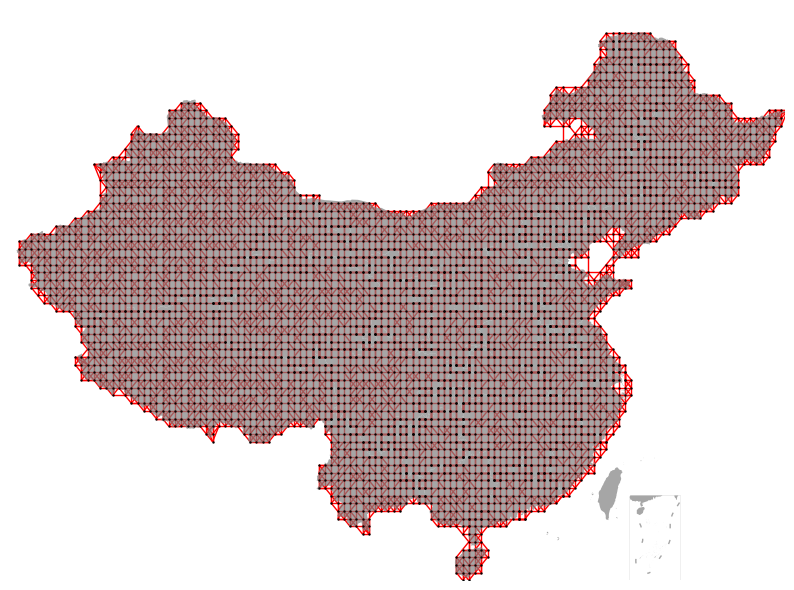

In [12]:
centroids = gdf.geometry.centroid
pos = {i: (centroid.x, centroid.y) for i, centroid in enumerate(centroids)}

# 绘制图形
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(
    G, pos,
    ax=ax,
    node_size=0.5,
    node_color="black",
    edge_color="red",
    with_labels=False
)
china.plot(color='grey', lw=1, alpha=0.7, ax=ax)
# plt.title('空间邻接矩阵', fontsize=25)
plt.xlim(73,135)
plt.ylim(18,55)
plt.show()

## 构建Graph

In [13]:
import numpy as np
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from geopy.distance import great_circle  # Haversine
from scipy.sparse import lil_matrix

### 边权重

In [14]:
# 初始化邻接矩阵
centroids = gdf.geometry.centroid
coords = centroids.apply(lambda point: (point.y, point.x)).tolist()

adj_matrix_sparse = lil_matrix(adj_matrix)  # 构建稀疏邻接矩阵
rows, cols = adj_matrix_sparse.nonzero()  # 获取非零元素的索引，表示相邻节点对
weight_matrix_sparse = lil_matrix(adj_matrix.shape)  # 初始化稀疏的权重矩阵

C:\Users\15499\AppData\Local\Temp\ipykernel_11088\2420102710.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.geometry.centroid


In [15]:
# 仅计算邻接矩阵中非零元素对应点对的距离，并使用倒数作为权重
for i, j in zip(rows, cols):
    if i < j:  # 只计算上三角
        # 使用Haversine计算i和j点之间的距离
        distance = great_circle(coords[i], coords[j]).kilometers
        # 计算距离的倒数作为权重，并填入稀疏矩阵
        weight_matrix_sparse[i, j] = 1 / (distance + 1e-6)  # 避免除以0
        weight_matrix_sparse[j, i] = weight_matrix_sparse[i, j]  # 对称赋值

# 将权重矩阵应用于图G
for i, j in zip(rows, cols):
    if i < j:
        G[i][j]['weight'] = weight_matrix_sparse[i, j]

In [19]:
# adj_matrix = nx.to_pandas_adjacency(G, weight='weight')
# adj_matrix['FID'] = adj_matrix.index

# first_column = adj_matrix.pop('FID')
# adj_matrix.insert(0, 'FID', first_column)
# adj_matrix.to_csv('邻接矩阵.csv', index=False)

In [12]:
G[0][1]

{'weight': 0.017986406386347017}

### 节点特征

- 直接读取csv用torch转

In [21]:
path = 'data/CSV/日降雨量汇总/'
csvs = glob.glob(path + '*.csv')
df = pd.read_csv(csvs[0]).fillna(0).sort_values('FID').reset_index(drop=True)
df_standardized = df.drop(columns=['FID','ENG_NAME']).apply(lambda x: (x - x.mean()) / x.std(), axis=0)  # 列上进行归一化

In [17]:
df_standardized

,rain,dem,aspect,hillshade,slope,cropland,forest,grass,shrub,wetland,buildup
0,-0.279993,1.664602,-1.985273,-3.897098,0.566333,-0.709263,-0.660071,-1.652169,-0.896919,-0.439590,-8.940733
1,-0.279993,1.837352,-0.269133,-2.158709,2.218102,-0.709263,-0.660071,1.667887,-0.896919,-0.438515,0.111826
2,-0.279993,1.572041,-0.661258,-2.298556,2.207030,-0.709263,-0.660071,1.668072,-0.896919,-0.439590,0.111826
3,-0.279993,1.000106,-1.148030,-4.288077,0.931724,-0.709263,-0.660071,-1.652169,-0.896919,-0.439590,-8.940733
4,-0.279993,1.649845,0.262087,-3.424962,0.970416,-0.709263,-0.660071,-0.026661,1.720910,-0.439590,0.111826
...,...,...,...,...,...,...,...,...,...,...,...
5095,-0.279993,-0.979621,-0.260450,-3.141967,-0.893905,-0.483196,-0.635314,1.036825,-0.896919,2.150047,0.111826
5096,-0.279993,-0.983617,-0.878868,-3.393233,-0.982132,-0.152836,-0.656250,0.858662,-0.896919,1.814866,0.111826
5097,-0.279993,-0.982604,-1.025151,-2.650035,-0.984620,1.447962,-0.640712,-0.986469,-0.896919,5.464676,0.111826
5098,-0.279993,-0.987879,0.012684,-3.484158,-0.986995,0.016962,-0.340622,0.362361,-0.895357,2.741027,0.111826


In [18]:
# 将DataFrame转换为字典，键为节点（FID），值为特征字典
features_dict = df_standardized.to_dict(orient='index')

# 将特征字典直接设置为图 G 的节点属性
nx.set_node_attributes(G, features_dict)

In [19]:
G.nodes[0]

{'rain': -0.27999295861296564,
 'dem': 1.6646015460090045,
 'aspect': -1.9852727524312597,
 'hillshade': -3.89709838009231,
 'slope': 0.5663333691081752,
 'cropland': -0.7092625445195365,
 'forest': -0.660070835309426,
 'grass': -1.6521693785175078,
 'shrub': -0.8969192657354614,
 'wetland': -0.43959039213349105,
 'buildup': -8.940732856702919}

## 处理数据集格式-torch

In [13]:
import torch
from torch_geometric.data import Data

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 处理边

In [14]:
# 通过G的参数构建torch_geometry
adj_matrix = nx.to_numpy_array(G, weight='weight')
edge_index = torch.tensor(np.array(G.edges()).T, dtype=torch.long)  # 转换为边索引格式
edge_weights = torch.tensor([G[u][v]['weight'] for u, v in G.edges()], dtype=torch.float)  # 获取边权重

In [15]:
graph = Data(edge_index=edge_index, edge_attr=edge_weights)
graph

Data(edge_index=[2, 14897], edge_attr=[14897])

### 处理节点和标签

In [26]:
# 获取所有文件及其对应的日期
csvs = glob.glob('data/CSV/Q3数据集带标签/*.csv')
file_dates = {csv: os.path.basename(csv).split('.')[0] for csv in csvs}
sorted_csvs = sorted(file_dates.keys(), key=lambda x: file_dates[x])  # 按日期排序文件

In [17]:
# 逐日构建数据集

def load_data(data_path):
    features_list = []
    labels_list = []

    for file in tqdm(data_path, desc="Processing", ncols=100):
        df = pd.read_csv(file)
        
        # 提取特征列和标签列
        features = df[['rain', 'dem', 'aspect', 'hillshade', 'slope', 'cropland', 
                       'forest', 'grass', 'shrub', 'wetland', 'buildup']].values
        labels = df['y'].values
        
        features_list.append(torch.tensor(features, dtype=torch.float))
        labels_list.append(torch.tensor(labels, dtype=torch.long))

    return features_list, labels_list

# 加载数据
features_list, labels_list = load_data(sorted_csvs)

Processing: 100%|█████████████████████████████████████████████| 11322/11322 [03:04<00:00, 61.31it/s]


In [35]:
# torch.save(features_list, 'features.pt')
# torch.save(labels_list, 'labels.pt')

## 模型

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric.nn as pyg_nn

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### GCN-LSTM-BI

In [19]:
class GCN_CONV(pyg_nn.MessagePassing):
    def __init__(self, in_channels, out_channels, activation=None, use_batch_norm=False, residual=False):
        super(GCN_CONV, self).__init__(aggr='add')
        self.linear = nn.Linear(in_channels, out_channels)
        self.use_batch_norm = use_batch_norm
        self.batch_norm = nn.BatchNorm1d(out_channels) if use_batch_norm else None
        self.activation = activation or nn.ReLU()
        self.residual = residual
        
        # For residual connection, the in_channels and out_channels must be same
        if self.residual and in_channels != out_channels:
            raise ValueError("For residual connections, in_channels and out_channels must be the same.")

    def forward(self, x, edge_index, edge_weight):
        out = self.linear(x)
        
        # Residual connection
        if self.residual:
            out += x
            
        out = self.propagate(edge_index, x=out, edge_weight=edge_weight)
        
        if self.use_batch_norm:
            out = self.batch_norm(out)
            
        return self.activation(out)

    def message(self, x_j, edge_weight):
        return x_j if edge_weight is None else x_j * edge_weight.view(-1, 1)

In [20]:
class GCN_LSTM_BI(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_gcn_layers, num_rnn_layers, num_predictions, num_classes=None, dropout=0):
        super(GCN_LSTM_BI, self).__init__()
        self.hidden_channels = hidden_channels
        self.num_rnn_layers = num_rnn_layers
        self.num_directions = 2  # For bidirectional LSTM
        self.num_predictions = num_predictions

        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        # 初始化第一个 GCN 层
        self.layers.append(GCN_CONV(in_channels, hidden_channels))
        self.batch_norms.append(nn.BatchNorm1d(hidden_channels))
        self.dropouts.append(nn.Dropout(dropout))

        # 初始化中间 GCN 层
        for _ in range(num_gcn_layers - 2):
            self.layers.append(GCN_CONV(hidden_channels, hidden_channels))
            self.batch_norms.append(nn.BatchNorm1d(hidden_channels))
            self.dropouts.append(nn.Dropout(dropout))

        # 初始化双向 LSTM
        self.bilstm = nn.LSTM(hidden_channels, hidden_channels, num_layers=num_rnn_layers, batch_first=True, bidirectional=True)
        if num_classes:
            # 输出层，输出每个节点的未来步长的分类预测
            self.output_layer = nn.Linear(hidden_channels * self.num_directions, num_classes * num_predictions)
        else:
            self.output_layer = nn.Linear(hidden_channels * self.num_directions, num_predictions)

    def forward(self, x, edge_index, edge_weight):
        seq_len, num_nodes, num_features = x.size()  # 输入的维度 (seq_len, num_nodes, num_features)
    
        gcn_outputs = []
        for t in range(seq_len):
            out = x[t]  # 当前时间步的节点特征
            for i, layer in enumerate(self.layers):  # 依次通过 GCN 层
                out = layer(out, edge_index, edge_weight)
                out = self.batch_norms[i](out)
                out = torch.relu(out)
                out = self.dropouts[i](out)
            
            gcn_outputs.append(out)
    
        # 堆叠所有时间步的输出，得到 (seq_len, num_nodes, hidden_channels)
        gcn_outputs = torch.stack(gcn_outputs, dim=0)
    
        # 输入到双向 LSTM，调整维度为 (num_nodes, seq_len, hidden_channels)
        gcn_outputs = gcn_outputs.permute(1, 0, 2)
    
        # LSTM 处理，输出 (num_nodes, seq_len, 2 * hidden_channels)
        lstm_out, _ = self.bilstm(gcn_outputs)

        # 只选择最后一个时间步的输出
        lstm_out_last = lstm_out[:, -1, :]  # (num_nodes, 2 * hidden_channels)

        # 输出层，将 hidden state 映射到每个预测步长的分类结果
        out = self.output_layer(lstm_out_last)  # (num_nodes, num_predictions * num_classes)

        # 调整输出维度为 (num_nodes, num_predictions, num_classes)
        out = out.view(num_nodes, self.num_predictions, -1)

        return out.squeeze(1)

## 初始化

In [29]:
# 设置超参数
num_epochs = 10
T = 30   # 使用前10个时间步预测
num_features = 11
hidden_channels = 32
num_gcn_layers = 3
num_rnn_layers = 2
num_predictions = 10  # 需要预测的长度
num_classes = None # 类别数量

# 初始化模型、损失函数和优化器
model = GCN_LSTM_BI(in_channels=num_features, hidden_channels=hidden_channels, 
                    num_gcn_layers=num_gcn_layers, num_rnn_layers=num_rnn_layers, 
                    num_predictions=num_predictions, num_classes=num_classes).to(device)
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 训练

In [36]:
# graph = torch.load('graph.pt')
graph = graph.to(device)

rmse_all = []
mae_all = []
r2_all = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    all_labels = []
    all_preds = []
    
    # 遍历数据，以 T 个时间步预测第 T + num_predictions 个时间步
    for t in range(len(features_list) - T - num_predictions):
        # 使用前 T 个时间步的特征作为输入，预测第 T + num_predictions 步
        features_tensor = torch.stack(features_list[t:t+T]).to(device)  # (T, num_nodes, num_features)
        # labels_T_next_1 = labels_list[t + T: t + T + num_predictions].to(device).float().unsqueeze(1)  # 第 T + num_predictions 时间步的标签
        labels_T_next_1 = torch.stack(labels_list[t + T: t + T + num_predictions]).to(device).type(torch.float32).unsqueeze(0).permute(2, 1, 0) 
    
        optimizer.zero_grad()
        
        output = model(features_tensor, graph.edge_index, graph.edge_attr)

        loss = criterion(output, labels_T_next_1)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        all_labels.append(labels_T_next_1.cpu().numpy())
        all_preds.append(output.cpu().detach().numpy())
    
    # 计算每个epoch的评估指标
    all_labels = np.concatenate(all_labels)  # 合并所有标签
    all_preds = np.concatenate(all_preds)    # 合并所有预测值

    rmse = mean_squared_error(all_labels, all_preds, squared=False)  
    mae = mean_absolute_error(all_labels, all_preds)                
    r2 = r2_score(all_labels, all_preds)
    rmse_all.append(rmse)
    mae_all.append(mae)
    r2_all.append(r2)
    # 打印结果
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

D:\Anaconda3\envs\Math\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


ValueError: Found array with dim 3. None expected <= 2.

In [39]:
all_labels_flat = all_labels.ravel()  # 展平成一维数组
all_preds_flat = all_preds.ravel()    # 展平成一维数组

rmse = mean_squared_error(all_labels_flat, all_preds_flat, squared=False)
mae = mean_absolute_error(all_labels_flat, all_preds_flat)
r2 = r2_score(all_labels_flat, all_preds_flat)

D:\Anaconda3\envs\Math\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [42]:
mae

0.0014489262

In [41]:
r2

-0.0033646821975708008